In [64]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
import json
from sklearn.cluster import KMeans
from math import ceil

In [65]:
# --- Load city from JSON ---
def load_city(filename="city.json"):
    with open(filename, "r") as f:
        data = json.load(f)

    G = nx.Graph()
    for n, attr in data["nodes"].items():
        G.add_node(int(n), pos=tuple(attr["pos"]))
    for edge in data["edges"]:
        G.add_edge(int(edge["u"]), int(edge["v"]), weight=float(edge["weight"]))
    return G

In [66]:
# --- Shortest path ---
def shortest_path(G, u, v):
    return nx.shortest_path(G, u, v, weight="weight"), \
           nx.shortest_path_length(G, u, v, weight="weight")

In [67]:
# --- TSP for small cluster ---
def tsp_route(G, employees, office):
    best_route, best_dist = None, float("inf")
    for perm in itertools.permutations(employees):
        total_dist = 0
        route = [perm[0]]
        current = perm[0]
        for nxt in perm[1:]:
            p, d = shortest_path(G, current, nxt)
            total_dist += d
            route.extend(p[1:])
            current = nxt
        p, d = shortest_path(G, current, office)
        total_dist += d
        route.extend(p[1:])
        if total_dist < best_dist:
            best_route, best_dist = route, total_dist
    return best_route, best_dist


In [68]:
def cluster_employees_with_capacity(G, employees, car_capacity, office):
    coords = np.array([G.nodes[e]['pos'] for e in employees])
    num_cars = ceil(len(employees) / car_capacity)

    # Step 1: KMeans clustering
    kmeans = KMeans(n_clusters=num_cars, n_init=10, random_state=42)
    labels = kmeans.fit_predict(coords)

    clusters = {}
    for emp, label in zip(employees, labels):
        clusters.setdefault(label, []).append(emp)

    # Step 2: Enforce capacity (≤ car_capacity)
    final_clusters = []
    for group in clusters.values():
        if len(group) <= car_capacity:
            final_clusters.append(group)
        else:
            # Split into chunks of max car_capacity
            for i in range(0, len(group), car_capacity):
                final_clusters.append(group[i:i+car_capacity])

    # Step 3: Handle under-capacity clusters
    merged = []
    skip = set()
    for i in range(len(final_clusters)):
        if i in skip:
            continue
        if len(final_clusters[i]) < car_capacity:
            pos_i = np.mean([G.nodes[e]['pos'] for e in final_clusters[i]], axis=0)
            office_dist_i = np.linalg.norm(np.array(G.nodes[office]['pos']) - pos_i)

            # Try to find nearest cluster j
            best_j, best_dist = None, float("inf")
            for j in range(i+1, len(final_clusters)):
                if j in skip or len(final_clusters[i]) + len(final_clusters[j]) > car_capacity:
                    continue
                pos_j = np.mean([G.nodes[e]['pos'] for e in final_clusters[j]], axis=0)
                dist_ij = np.linalg.norm(pos_i - pos_j)
                if dist_ij < best_dist:
                    best_j, best_dist = j, dist_ij

            # Merge condition: office_dist * 2 > dist_ij
            if best_j is not None and office_dist_i * 2 > best_dist:
                final_clusters[i] += final_clusters[best_j]
                skip.add(best_j)

        merged.append(final_clusters[i])

    return merged


In [69]:
# --- Full VRP solution ---
def solve_vrp(G, employees, office, car_capacity=4):
    clusters = cluster_employees_with_capacity(G, employees, car_capacity, office)
    routes = []
    total_dist = 0
    for group in clusters:
        r, d = tsp_route(G, group, office)
        routes.append((group, r, d))
        total_dist += d
    return routes, total_dist

In [70]:
# --- Visualization ---
def draw_solution(G, employees, office, routes):
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, node_size=10, node_color="lightblue", edge_color="gray", with_labels=False)

    # Office black, employees green
    nx.draw_networkx_nodes(G, pos, nodelist=[office], node_size=100, node_color="black")
    nx.draw_networkx_nodes(G, pos, nodelist=employees, node_size=60, node_color="green")

    colors = plt.cm.get_cmap("tab20", len(routes))
    for i, (_, route, _) in enumerate(routes):
        edges = list(zip(route, route[1:]))
        nx.draw_networkx_nodes(G, pos, nodelist=route, node_size=30, node_color=[colors(i)])
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, edge_color=[colors(i)])

    plt.show()

In [71]:
# --- Example run ---
G = load_city("city.json")

Total cars used: 28
Car 1: Employees [73, 161, 445, 420] → distance 76.29
Car 2: Employees [365, 369, 225, 228] → distance 94.40
Car 3: Employees [468, 37, 755, 206] → distance 100.38
Car 4: Employees [244, 247, 265, 309] → distance 22.80
Car 5: Employees [353, 952, 949] → distance 46.24
Car 6: Employees [360, 941, 756, 279] → distance 97.94
Car 7: Employees [500, 583, 192] → distance 85.30
Car 8: Employees [738, 332, 566] → distance 71.17
Car 9: Employees [611, 899, 828] → distance 52.42
Car 10: Employees [42, 133, 655, 966] → distance 88.64
Car 11: Employees [393, 525, 423] → distance 54.41
Car 12: Employees [790, 456, 929] → distance 82.08
Car 13: Employees [581, 577, 146, 801] → distance 59.80
Car 14: Employees [284, 411, 529, 282] → distance 103.77
Car 15: Employees [678, 419, 546, 315] → distance 135.98
Car 16: Employees [94, 341, 878] → distance 71.56
Car 17: Employees [551, 629, 396, 660] → distance 102.10
Car 18: Employees [849, 436, 472, 963] → distance 88.45
Car 19: Employee

C:\Users\Yash Malhotra\AppData\Local\Temp\ipykernel_35172\805989476.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(routes))


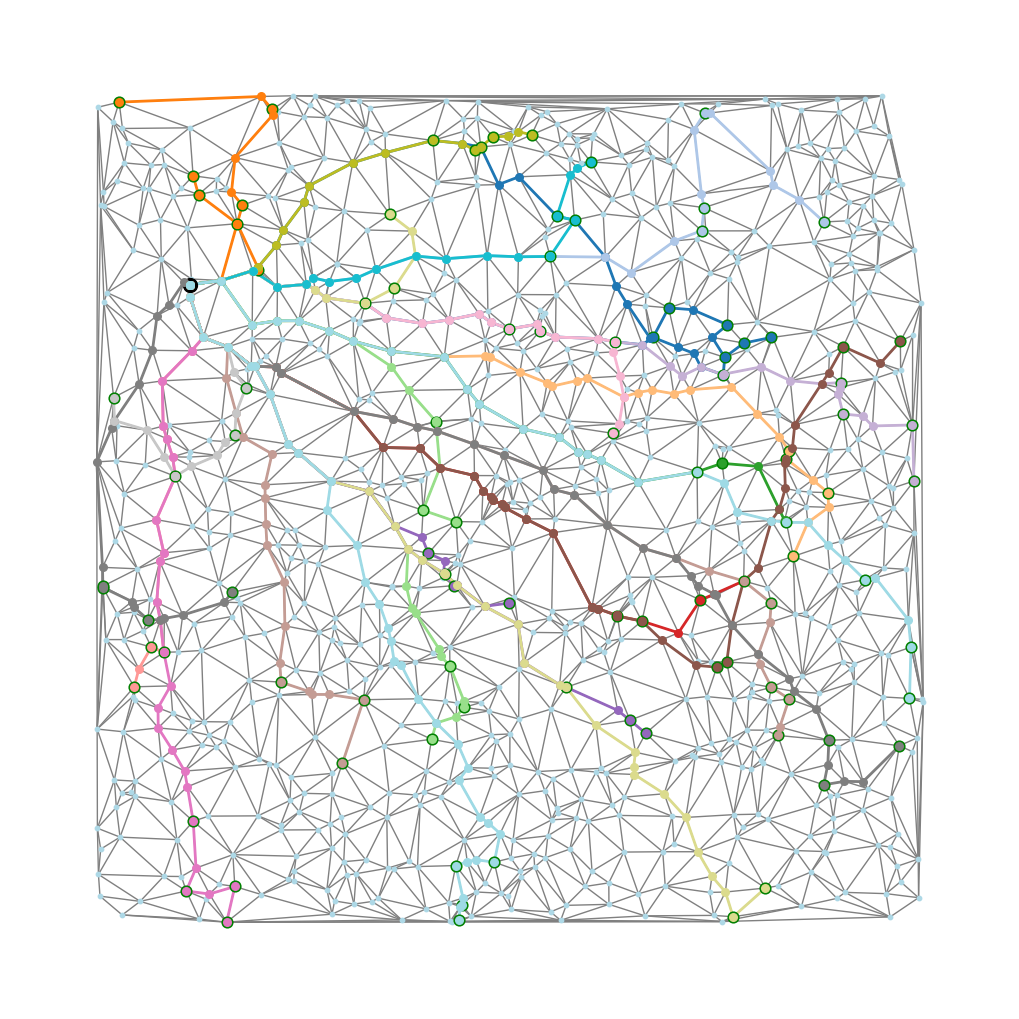

In [72]:
# Pick 100 random employees
all_nodes = list(G.nodes())
employees = [73,468,244,247,161,360,738,611,265,42,393,790,581,456,284,37,94,941,577,551,849,445,980,713,341,629,517,332,420,411,999,133,686,365,702,779,159,309,654,756,353,901,416,566,755,221,687,206,279,396,88,995,82,660,529,897,525,899,436,528,472,828,65,546,395,190,125,423,165,500,583,146,326,369,658,282,952,623,27,655,678,419,192,375,43,272,248,168,791,225,253,966,801,878,929,949,228,315,963,222]
office = 600

routes, total_dist = solve_vrp(G, employees, office, car_capacity=4)

print(f"Total cars used: {len(routes)}")
for i, (group, r, d) in enumerate(routes):
    print(f"Car {i+1}: Employees {group} → distance {d:.2f}")

print(f"Total distance for all cars: {total_dist:.2f}")

draw_solution(G, employees, office, routes)